In [1]:
from __future__ import print_function
import numpy as np
import glob
import pandas as pd
from random import shuffle,seed

seed(2017)
np.random.seed(2017)

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
WIDTH  = 86
HEIGHT = 64

batch_size = 16
num_classes = 3
epochs = 20


print( tensorflow.__version__,keras.__version__)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
1.3.0 2.0.8


In [62]:
def build_train_set():
    
    dataset = []
    
    colors = {"red": 0, "yellow":1, "green": 2 }
    datagen = ImageDataGenerator(rotation_range=0.5,width_shift_range=0.01,
                                    height_shift_range=0.01,)
    
    for color in colors.keys():
        path = "/disk/projects/selfdriving/shared/set1/%s/*.jpg" % color
        print(path)
        images =  glob.glob(path)     
        
        for im_file in images:
            label = colors[color]
            img = cv2.imread(im_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize( img, (WIDTH, HEIGHT))
            ## flip image for data augmentation
            img2 = cv2.flip( img.copy(), 1 )
            
            dataset.append( (np.array(img),  label))
            dataset.append( (np.array(img2), label))

            
            if 'left' in im_file:
                #print(im_file)
                continue
            
            thesh = 15 if label==1 else 8
            
            
            i = 0
            for batch in datagen.flow(img.reshape(1,  HEIGHT, WIDTH, 3), batch_size=1):
                i+=1
                dataset.append( (np.array(batch[0]), label) )                
                if i > thesh:
                    break  # otherwise the generator would loop indefinitely

                
            

            
    shuffle(dataset)
        
    return np.array(dataset)

In [63]:
dataset = build_train_set()

len(dataset)

/disk/projects/selfdriving/shared/set1/green/*.jpg
/disk/projects/selfdriving/shared/set1/yellow/*.jpg
/disk/projects/selfdriving/shared/set1/red/*.jpg


7641

In [66]:
r = np.random.rand( dataset.shape[0])
train = dataset[r<.75]
test = dataset[r>=.75]

In [67]:
train.shape, test.shape
x_train = np.array([ img for img in train[:,0]])
y_train = train[:,1]

x_test = np.array([ img for img in test[:,0]])
y_test = test[:,1]

In [68]:
# input image dimensions
img_rows, img_cols = HEIGHT, WIDTH


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5756, 64, 86, 3)
5756 train samples
1885 test samples


In [69]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks =[es]
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5756 samples, validate on 1885 samples
Epoch 1/20
5756/5756 [==============================] - 31s - loss: 0.5378 - acc: 0.7688 - val_loss: 0.1761 - val_acc: 0.9570
Epoch 2/20
5756/5756 [==============================] - 30s - loss: 0.1226 - acc: 0.9607 - val_loss: 0.1090 - val_acc: 0.9671
Epoch 3/20
5756/5756 [==============================] - 30s - loss: 0.0601 - acc: 0.9823 - val_loss: 0.0707 - val_acc: 0.9809
Epoch 4/20
5756/5756 [==============================] - 30s - loss: 0.0304 - acc: 0.9899 - val_loss: 0.0431 - val_acc: 0.9873
Epoch 5/20
5756/5756 [==============================] - 30s - loss: 0.0213 - acc: 0.9944 - val_loss: 0.0561 - val_acc: 0.9883
Epoch 6/20
5756/5756 [==============================] - 29s - loss: 0.0158 - acc: 0.9946 - val_loss: 0.0296 - val_acc: 0.9894
Epoch 7/20
5756/5756 [==============================] - 29s - loss: 0.0100 - acc: 0.9964 - val_loss: 0.0289 - val_acc: 0.9915
Epoch 8/20
5756/5756 [==============================] - 29s - loss: 0.

In [71]:
model.save("/disk/projects/selfdriving/shared/model/model_8_keep_aspect_ratio.hd5")

In [72]:
WIDTH, HEIGHT

(86, 64)

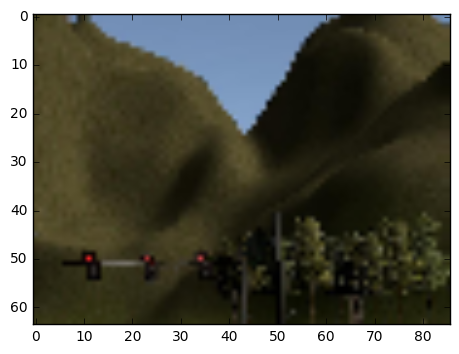

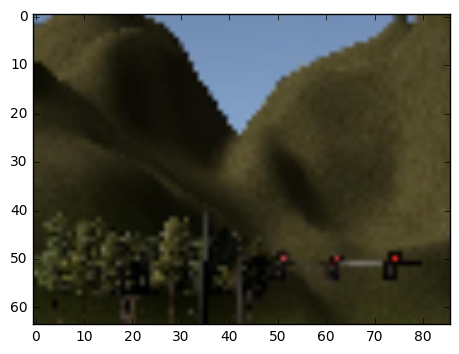

In [73]:
plt.imshow( x_test[122])

fimg = cv2.flip( x_test[122], 1 )
plt.show()
plt.imshow( fimg)

In [74]:
del model

from keras.models import load_model
model = load_model("/disk/projects/selfdriving/shared/model/model_8_keep_aspect_ratio.hd5")

In [77]:
%time ret = model.predict( fimg.reshape( 1, HEIGHT, WIDTH, 3) )

CPU times: user 6.16 ms, sys: 3.85 ms, total: 10 ms
Wall time: 8.24 ms


In [78]:
ret, np.argmax(ret)

(array([[  9.92002487e-01,   7.66854780e-03,   3.28951690e-04]], dtype=float32),
 0)

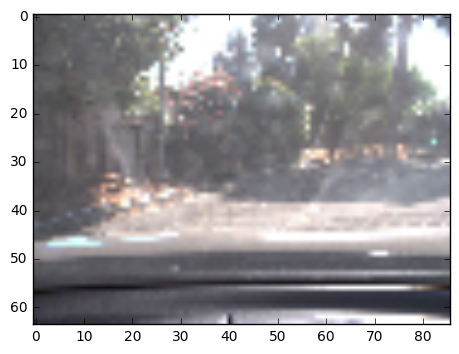

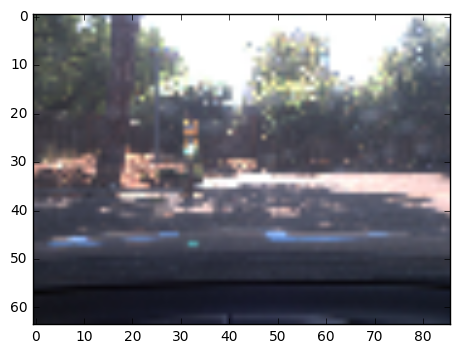

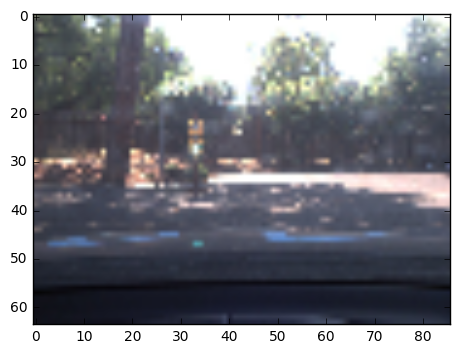

In [85]:
images = glob.glob("/disk/projects/selfdriving/shared/set1/green/*.jpg")
results = []
for im_file in images:
    test_img = cv2.imread(im_file)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize( test_img, (WIDTH, HEIGHT))
    test_img = test_img.astype('float32')/255
    
    ret = model.predict( test_img.reshape( 1, HEIGHT, WIDTH, 3) )
    results.append( np.argmax(ret))
    
    if np.argmax(ret)<>2:
        plt.imshow(test_img)
        plt.show()


In [87]:
results= np.array(results)
results[results<>2].shape, results.shape

((3,), (344,))